<a href="https://colab.research.google.com/github/cesargar1507/DatasetsUB/blob/main/testAeromanCesarGarcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [412]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool


In [413]:
ruta = "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/movements.csv"
data = pd.read_csv(ruta, sep=",")

In [414]:
data.columns = ['turno', 'matricula', 'aerolinea2', 'inicia_movimiento', 'punto_de_inicio',
                'punto_de_finalizacion', 'motivo_movimiento', 'finaliza_movimiento']

In [415]:
data.head(5)

,turno,matricula,aerolinea2,inicia_movimiento,punto_de_inicio,punto_de_finalizacion,motivo_movimiento,finaliza_movimiento
0,BRAVO,AC241,M,7/1/2022 7:21,INTERIOR H5,RAMPA H5/H6,REALIZAR CORRIDA DE MOTORES,7/1/2022 7:29
1,BRAVO,AC81,K,7/1/2022 11:25,PISTA ALFA,RAMPA H6,INICIO MANTENIMIENTO,7/1/2022 11:30
2,BRAVO,AC241,M,7/1/2022 8:47,RAMPA H5/H6,INTERIOR H5,CAMBIO DE POSICION,7/1/2022 8:54
3,BRAVO,AC43,J,7/1/2022 7:37,INTERIOR H4,Avisame,REALIZAR CORRIDA DE MOTORES,7/1/2022 7:42
4,BRAVO,AC43,J,7/1/2022 7:53,RAMPA H3,RAMPA H3,ESPACIO,7/1/2022 8:03


In [416]:
data.isna().sum()

turno                    0
matricula                0
aerolinea2               0
inicia_movimiento        0
punto_de_inicio          0
punto_de_finalizacion    1
motivo_movimiento        0
finaliza_movimiento      0
dtype: int64

In [417]:
data = data.dropna()

In [418]:
# Convertir las fechas y horas a formato datetime
data['inicia_movimiento'] = pd.to_datetime(data['inicia_movimiento'])
data['finaliza_movimiento'] = pd.to_datetime(data['finaliza_movimiento'])

In [419]:
# Calcular la duración del movimiento en minutos
data['duracion_min'] = (data['finaliza_movimiento'] - data['inicia_movimiento']).dt.total_seconds() / 60

In [420]:
data['duracion_min'].describe()

count    5183.000000
mean        7.949836
std        42.913781
min     -1418.000000
25%         5.000000
50%         7.000000
75%        12.000000
max       161.000000
Name: duracion_min, dtype: float64

Se identifican casos atipicos donde el tiempo de finalizacion del movimiento es previo al tiempo de inicio, esos datos seran eliminados del dataset

In [421]:
data = data[data['duracion_min'] >= 0]

In [422]:
data['duracion_min'].describe()

count    5155.000000
mean        9.962755
std         9.711365
min         0.000000
25%         5.000000
50%         7.000000
75%        12.000000
max       161.000000
Name: duracion_min, dtype: float64

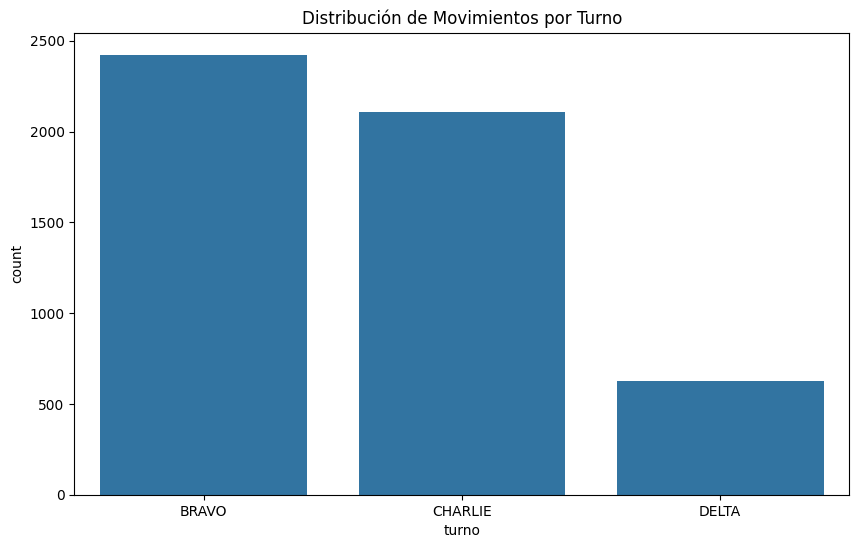

In [423]:
# Distribución de los movimientos por turno
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='turno')
plt.title('Distribución de Movimientos por Turno')
plt.show()

Se identifica que el turno con más movimientos es el turno "BRAVO" con más de 2000 movimientos acumulados

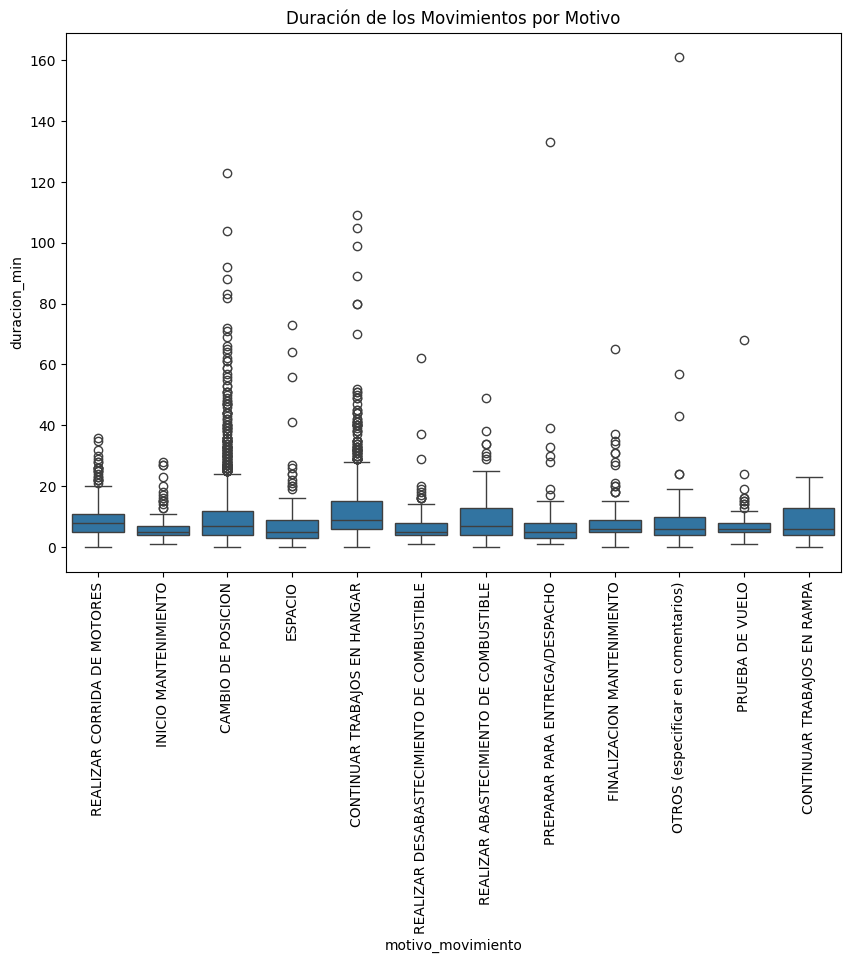

In [424]:
# Duración promedio de los movimientos por motivo
plt.figure(figsize=(10, 7))
sns.boxplot(data=data, x='motivo_movimiento', y='duracion_min')
plt.title('Duración de los Movimientos por Motivo')
plt.xticks(rotation=90)
plt.show()

In [425]:
data.groupby('motivo_movimiento')['duracion_min'].mean()


motivo_movimiento
CAMBIO DE POSICION                           10.107143
CONTINUAR TRABAJOS EN HANGAR                 12.015900
CONTINUAR TRABAJOS EN RAMPA                   8.564103
ESPACIO                                       8.258503
FINALIZACION MANTENIMIENTO                    8.005076
INICIO MANTENIMIENTO                          6.170616
OTROS (especificar en comentarios)           10.527027
PREPARAR PARA ENTREGA/DESPACHO                7.875000
PRUEBA DE VUELO                               7.636364
REALIZAR ABASTECIMIENTO DE COMBUSTIBLE        9.296443
REALIZAR CORRIDA DE MOTORES                   9.302632
REALIZAR DESABASTECIMIENTO DE COMBUSTIBLE     6.987097
Name: duracion_min, dtype: float64

En los gráficos de caja se observa que el movimiento que toma mayor tiempo es "Continuar trabajos en el hangar" de igual manera se observan outliers del mismo, en segundo lugar, el movimiento que toma más tiempo es "Otros" y en tercer lugar estan los "Cambios de posición"

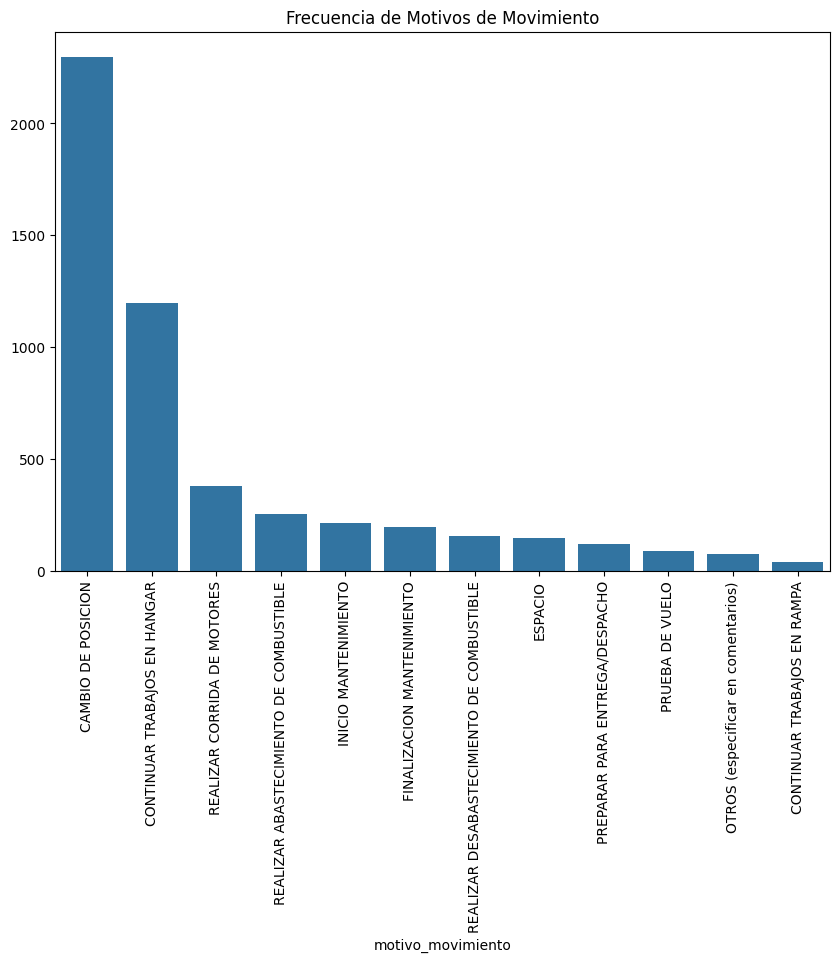

In [426]:
# Frecuencia de motivos de movimiento
plt.figure(figsize=(10, 7))
motivo_counts = data['motivo_movimiento'].value_counts()
sns.barplot(x=motivo_counts.index, y=motivo_counts.values)
plt.title('Frecuencia de Motivos de Movimiento')
plt.xticks(rotation=90)
plt.show()

El movimiento más frecuente es el cambio de posición seguido por continuar trabajos en el hangar, ambos tienen un alto promedio de duración en cuanto a los movimientos de las aeronaves por lo que, habría que enfocarse en primer lugar en optimizar los tiempos de ambos movimientos

In [427]:
# Movimientos que toman más tiempo de lo esperado (cuartil superior)
long_movements = data[data['duracion_min'] > data['duracion_min'].quantile(0.75)]
print("Movimientos más largos de lo esperado:")
long_movements

Movimientos más largos de lo esperado:


,turno,matricula,aerolinea2,inicia_movimiento,punto_de_inicio,punto_de_finalizacion,motivo_movimiento,finaliza_movimiento,duracion_min
8,BRAVO,AC15,C,2022-07-01 14:37:00,RAMPA H3,INTERIOR H4,CONTINUAR TRABAJOS EN HANGAR,2022-07-01 14:55:00,18.0
11,CHARLIE,AC81,K,2022-07-01 20:11:00,RAMPA H6,INTERIOR H6,CONTINUAR TRABAJOS EN HANGAR,2022-07-01 20:25:00,14.0
13,CHARLIE,AC81,K,2022-07-01 19:55:00,RAMPA H6,RAMPA H6,CAMBIO DE POSICION,2022-07-01 20:11:00,16.0
25,BRAVO,AC87,J,2022-07-02 12:04:00,INTERIOR H2,RAMPA H2,CAMBIO DE POSICION,2022-07-02 12:17:00,13.0
27,BRAVO,AC91,J,2022-07-02 12:16:00,RAMPA H3,INTERIOR H2,CONTINUAR TRABAJOS EN HANGAR,2022-07-02 12:30:00,14.0
...,...,...,...,...,...,...,...,...,...
5141,CHARLIE,AC189H,K,2022-07-25 18:41:00,INTERIOR H6,INTERIOR H6,CAMBIO DE POSICION,2022-07-25 19:02:00,21.0
5143,BRAVO,AC139,G,2022-08-11 10:55:00,INTERIOR H6,RAMPA H6,REALIZAR DESABASTECIMIENTO DE COMBUSTIBLE,2022-08-11 11:09:00,14.0
5146,CHARLIE,AU78,F,2022-08-17 19:41:00,RAMPA H4,INTERIOR H4,CONTINUAR TRABAJOS EN HANGAR,2022-08-17 20:21:00,40.0
5152,BRAVO,9870E,A,2022-08-23 06:39:00,CALLE DE RODAJE,RAMPA H5,INICIO MANTENIMIENTO,2022-08-23 06:54:00,15.0


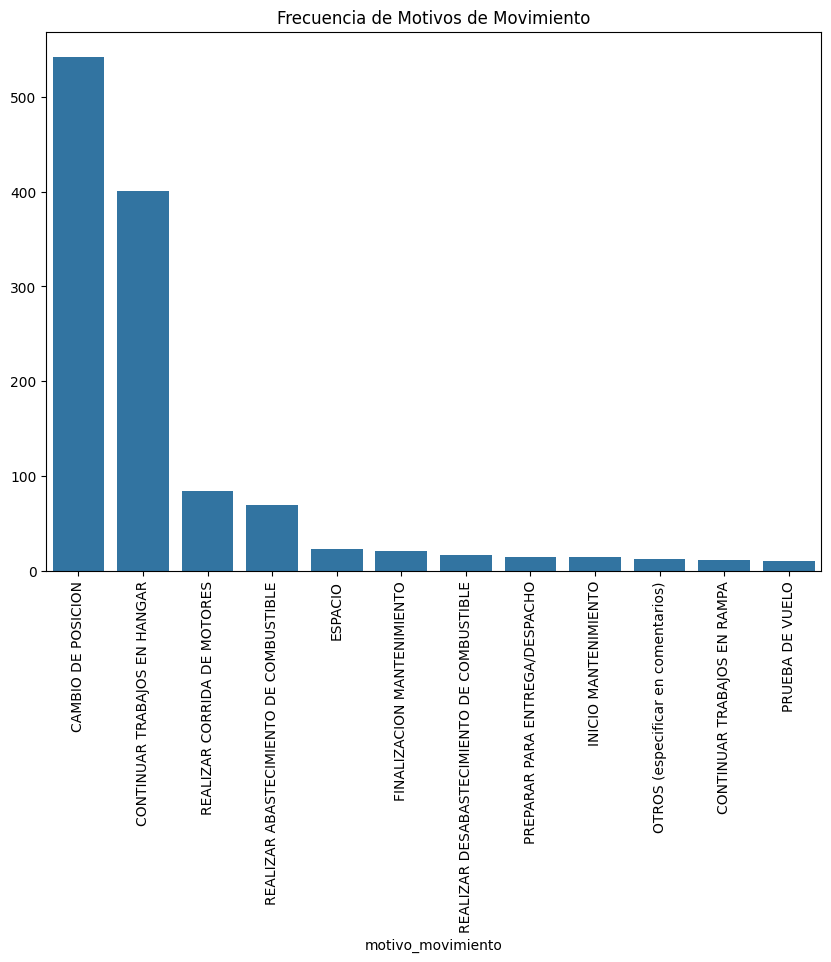

In [428]:
# Frecuencia de motivos de movimiento arriba del quantil 0.75
plt.figure(figsize=(10, 7))
motivo_counts = long_movements['motivo_movimiento'].value_counts()
sns.barplot(x=motivo_counts.index, y=motivo_counts.values)
plt.title('Frecuencia de Motivos de Movimiento')
plt.xticks(rotation=90)
plt.show()

Se valida que los movimientos que requieren de mayor tiempo son cambios de posición y continuar trabajos en el hangar

In [429]:
# Crear una nueva columna que contenga el concatenado de puntos de inicio y finalización
data.loc[:, 'inicio_fin_concat'] = data['punto_de_inicio'] + ' -> ' + data['punto_de_finalizacion']

In [430]:
# Filtrar el DataFrame para incluir solo los motivos de movimiento específicos
data_filtrado = data[data['motivo_movimiento'].isin(["CAMBIO DE POSICION", "CONTINUAR TRABAJOS EN HANGAR"])]

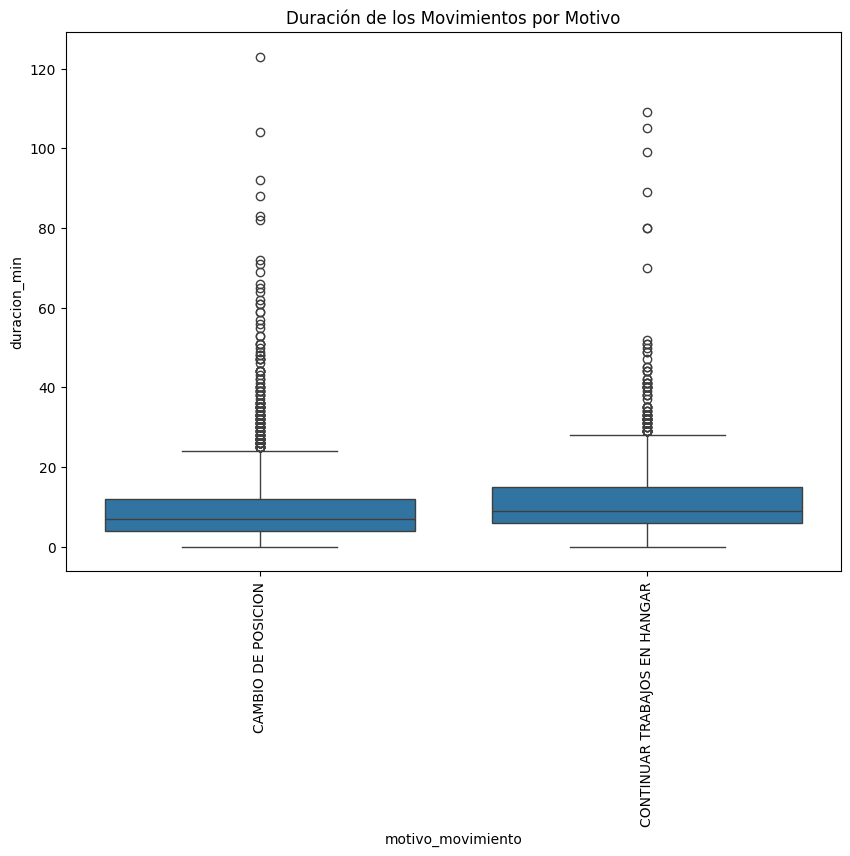

In [431]:
# Duración promedio de los movimientos por motivo
plt.figure(figsize=(10, 7))
sns.boxplot(data=data_filtrado, x='motivo_movimiento', y='duracion_min')
plt.title('Duración de los Movimientos por Motivo')
plt.xticks(rotation=90)
plt.show()

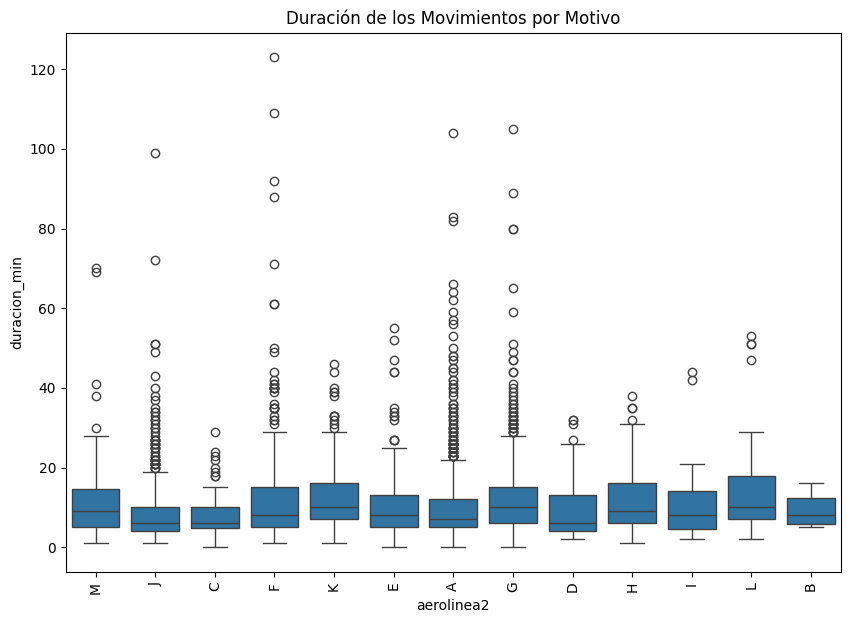

In [432]:
# Duración promedio de los movimientos por motivo
plt.figure(figsize=(10, 7))
sns.boxplot(data=data_filtrado, x='aerolinea2', y='duracion_min')
plt.title('Duración de los Movimientos por Motivo')
plt.xticks(rotation=90)
plt.show()

No se identifica una diferencia en cuanto a medianas por el cambio de areolinea en cuanto a la duración de los traslados

In [433]:
# Filtrar el DataFrame para incluir solo los movimientos de "CAMBIOS DE POSICION" y "CONTINUAR TRABAJOS EN HANGAR"
mov_cambios_posicion = data[data['motivo_movimiento'] == "CAMBIO DE POSICION"]
mov_continuar_hangar = data[data['motivo_movimiento'] == "CONTINUAR TRABAJOS EN HANGAR"]

# Agrupar los datos filtrados por la variable inicio_fin_concat
grupo_por_ubicacion_cambios = mov_cambios_posicion.groupby('inicio_fin_concat')
grupo_por_ubicacion_hangar = mov_continuar_hangar.groupby('inicio_fin_concat')

# Contar el número de movimientos para cada ubicación y calcular la duración promedio para cada ubicación
conteo_movimientos_cambios = grupo_por_ubicacion_cambios.size().reset_index(name='num_movimientos_cambios')
conteo_movimientos_hangar = grupo_por_ubicacion_hangar.size().reset_index(name='num_movimientos_hangar')

duracion_promedio_cambios = grupo_por_ubicacion_cambios['duracion_min'].mean().reset_index(name='duracion_promedio_cambios')
duracion_promedio_hangar = grupo_por_ubicacion_hangar['duracion_min'].mean().reset_index(name='duracion_promedio_hangar')

# Combinar las estadísticas en un solo DataFrame para cada tipo de movimiento
estadisticas_ubicaciones_cambios = pd.merge(conteo_movimientos_cambios, duracion_promedio_cambios, on='inicio_fin_concat')
estadisticas_ubicaciones_cambios = estadisticas_ubicaciones_cambios.nlargest(10, 'duracion_promedio_cambios')
estadisticas_ubicaciones_hangar = pd.merge(conteo_movimientos_hangar, duracion_promedio_hangar, on='inicio_fin_concat')
estadisticas_ubicaciones_hangar = estadisticas_ubicaciones_hangar.nlargest(10, 'duracion_promedio_hangar')

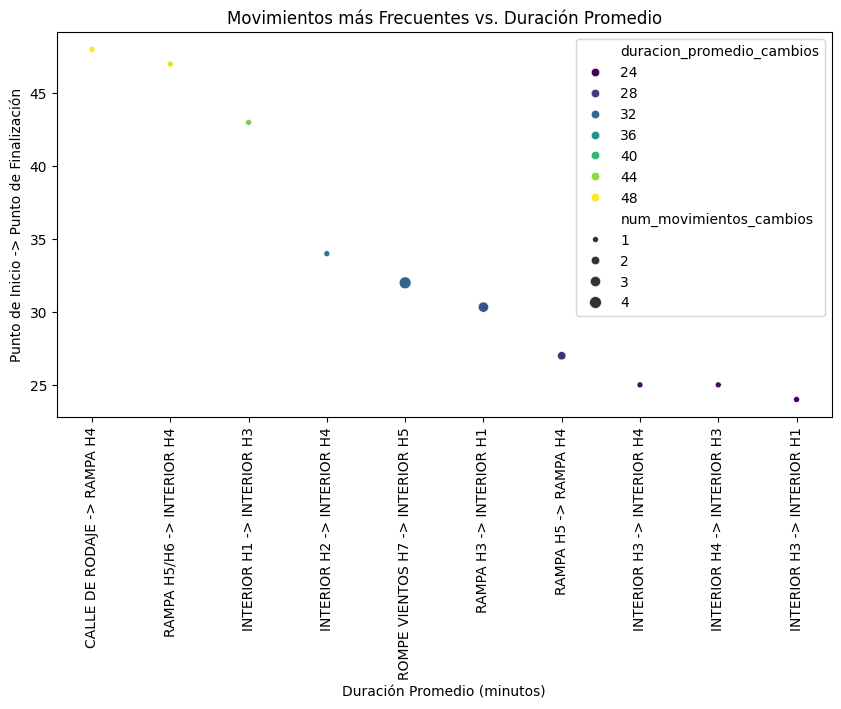

In [434]:
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 5))
sns.scatterplot(y='duracion_promedio_cambios', x='inicio_fin_concat', size='num_movimientos_cambios', data=estadisticas_ubicaciones_cambios, hue='duracion_promedio_cambios', palette='viridis')

# Ajustar etiquetas y título
plt.xlabel('Duración Promedio (minutos)')
plt.ylabel('Punto de Inicio -> Punto de Finalización')
plt.title('Movimientos más Frecuentes vs. Duración Promedio')
# Rotar las etiquetas del eje y
plt.xticks(rotation=90)
# Mostrar el gráfico
plt.show()

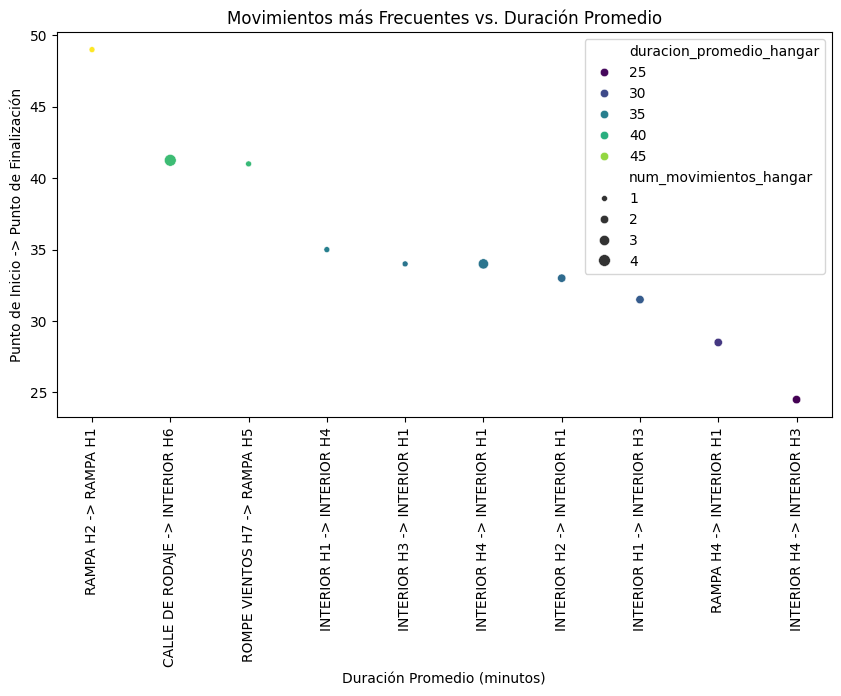

In [435]:
# Crear un gráfico de dispersión
plt.figure(figsize=(10, 5))
sns.scatterplot(y='duracion_promedio_hangar', x='inicio_fin_concat', size='num_movimientos_hangar', data=estadisticas_ubicaciones_hangar, hue='duracion_promedio_hangar', palette='viridis')

# Ajustar etiquetas y título
plt.xlabel('Duración Promedio (minutos)')
plt.ylabel('Punto de Inicio -> Punto de Finalización')
plt.title('Movimientos más Frecuentes vs. Duración Promedio')
# Rotar las etiquetas del eje y
plt.xticks(rotation=90)
# Mostrar el gráfico
plt.show()

Se identifica que los movimientos entre ubicaciones que han tardado más tiempo de lo habitual no son frecuentes en el tiempo, son posibles causas especiales por lo que, deberían ser investigadas in situ para dar una respuesta a las causas de los altos tiempos de duración por traslado

In [436]:
# Seleccionar características (variables independientes) y variable objetivo (duración_min)
X = data[['turno', 'motivo_movimiento', 'matricula', 'aerolinea2','punto_de_inicio','punto_de_finalizacion']]
y = data['duracion_min']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)
catboost_model.fit(X_train, y_train, cat_features=[0, 1, 2, 3, 4, 5], eval_set=(X_test, y_test), verbose=100)

# Hacer predicciones
y_pred_catboost = catboost_model.predict(X_test)

# Calcular métricas de evaluación
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print("Mean Squared Error (MSE) - CatBoost:", mse_catboost)
print("Coefficient of Determination (R^2) - CatBoost:", r2_catboost)

0:	learn: 9.7656631	test: 9.1492926	best: 9.1492926 (0)	total: 31.4ms	remaining: 31.4s
100:	learn: 8.8871825	test: 8.6609085	best: 8.6468355 (64)	total: 2.27s	remaining: 20.2s
200:	learn: 8.5422897	test: 8.7006321	best: 8.6468355 (64)	total: 3.35s	remaining: 13.3s
300:	learn: 8.2708705	test: 8.7447066	best: 8.6468355 (64)	total: 4.56s	remaining: 10.6s
400:	learn: 7.9530044	test: 8.7910295	best: 8.6468355 (64)	total: 6.26s	remaining: 9.35s
500:	learn: 7.6353341	test: 8.8486219	best: 8.6468355 (64)	total: 7.62s	remaining: 7.59s
600:	learn: 7.3476814	test: 8.8789924	best: 8.6468355 (64)	total: 8.96s	remaining: 5.95s
700:	learn: 7.0924868	test: 8.8905759	best: 8.6468355 (64)	total: 10.7s	remaining: 4.55s
800:	learn: 6.7882245	test: 8.9195556	best: 8.6468355 (64)	total: 12.2s	remaining: 3.03s
900:	learn: 6.5313481	test: 8.9315569	best: 8.6468355 (64)	total: 14.9s	remaining: 1.64s
999:	learn: 6.3255939	test: 8.9431841	best: 8.6468355 (64)	total: 17.4s	remaining: 0us

bestTest = 8.646835517
b

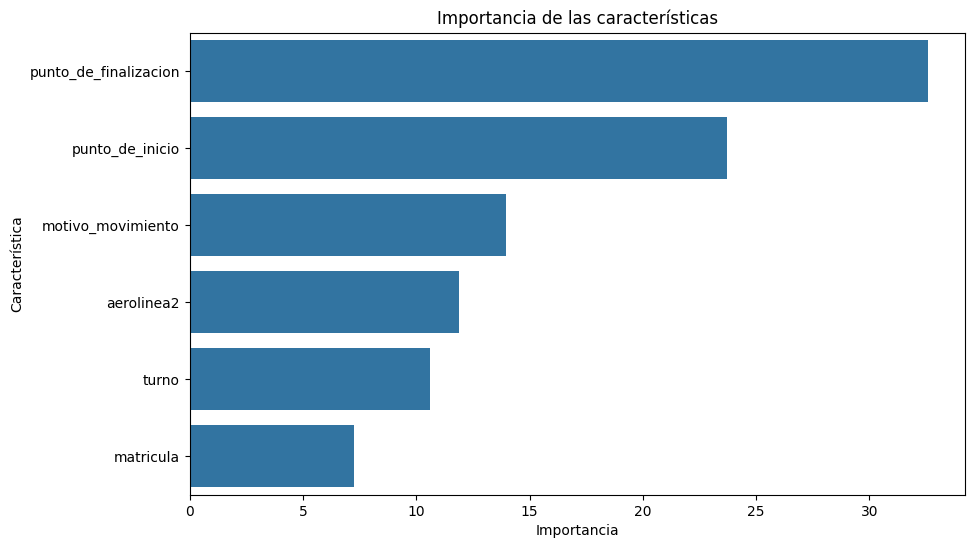

In [437]:
# Obtener un resumen de los parámetros del modelo
feature_importance = catboost_model.get_feature_importance()

# Obtener los nombres de las características
feature_names = X.columns

# Crear un DataFrame con la importancia de las características y sus nombres
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia de características
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de las características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

Se identifica que los factores de importancia para definir la duración de los traslados son en mayor medida el punto de fin, el punto de inicio y el motivo del movimiento, son los factores que explican en mayor medida la variable dependiente

In [438]:
# Definir manualmente los valores para cada característica del nuevo dato
nuevo_dato = pd.DataFrame({
    'turno': ['BRAVO'],
    'motivo_movimiento': ['REALIZAR DESABASTECIMIENTO DE COMBUSTIBLE'],
    'matricula': ['AC15'],
    'aerolinea2': ['C'],
    'punto_de_inicio': ['INTERIOR H4'],
    'punto_de_finalizacion': ['RAMPA H4']
})

# Realizar la predicción utilizando el modelo CatBoost
duracion_predicha = catboost_model.predict(nuevo_dato)

print("Duración predicha:", duracion_predicha)

Duración predicha: [5.59186514]


A falta de datos, no es posible establecer un modelo para predecir con un ajuste adecuado la duración de un movimiento con base a los predictores disponibles, sin embargo, con más datos podría realizarse un modelo más robusto para mejorar la exactitud, se propone realizar un modelo de clasificación

In [439]:
data.loc[:, 'categoria'] = np.where(data['duracion_min'] >= 9, "Mayor que la media", "Menor que la media")

In [440]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Seleccionar características (variables independientes) y variable objetivo (duracion_binaria)
X = data[['turno', 'motivo_movimiento', 'matricula', 'aerolinea2','punto_de_inicio','punto_de_finalizacion']]
y = data['categoria']

# Codificar variables categóricas utilizando one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo RandomForestClassifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest_classifier.fit(X_train, y_train)

# Hacer predicciones
y_pred_random_forest = random_forest_classifier.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred_random_forest)
classification_rep = classification_report(y_test, y_pred_random_forest)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.6304558680892337
Classification Report:
                     precision    recall  f1-score   support

Mayor que la media       0.65      0.14      0.24       408
Menor que la media       0.63      0.95      0.76       623

          accuracy                           0.63      1031
         macro avg       0.64      0.55      0.50      1031
      weighted avg       0.64      0.63      0.55      1031

